In [1]:
import time
import timeit
from IPython import display

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets, mixture
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split

from itertools import cycle, islice
from math import ceil
from tqdm import tqdm
import h5py
import shutil

import sys
sys.path.append('../../')

from evaluation import *
np.random.seed(10)
%matplotlib inline

/opt/conda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Подготовим данные

In [3]:
column_names = 'label, lepton 1 pT, lepton 1 eta, lepton 1 phi, lepton 2 pT, lepton 2 eta, lepton 2 phi, missing energy magnitude, missing energy phi, MET_rel, axial MET, M_R, M_TR_2, R, MT2, S_R, M_Delta_R, dPhi_r_b, cos(theta_r1)'.split(', ')
data = pd.read_csv('../../../../data/SUSY.csv', header=None, names=column_names)

In [4]:
data.head()

,label,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


In [5]:
data.shape

(5000000, 19)

Делим выборку на признаки и таргеты. Нормируем признаки.

$X_{new} = \frac{X - \mu}{\sigma}$

In [6]:
X_data = data.drop('label', 1)
X_data = StandardScaler().fit_transform(X_data)

labels = data["label"]

In [7]:
min_class_size = min(X_data[np.where(labels==0)[0]].shape[0], X_data[np.where(labels==1)[0]].shape[0])

In [8]:
min_class_size

2287827

In [9]:
X_0 = X_data[np.where(labels==0)[0]]
X_1 = X_data[np.where(labels==1)[0]]

In [10]:
np.concatenate((X_0[:min_class_size], X_1[:min_class_size])).shape

(4575654, 18)

In [11]:
X_data = np.concatenate((X_0[:min_class_size], X_1[:min_class_size]))
labels = np.concatenate((np.zeros((min_class_size,1)), np.ones((min_class_size,1)))).ravel()

Разбиваем на train(8% от всех данных) и test(2%)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
indx_train, indx_test = train_test_split(np.arange(len(labels), dtype='int32'), 
                                         stratify=labels, train_size=400000, test_size=100000, random_state=5)

In [14]:
indx_train = np.random.permutation(indx_train)
indx_test = np.random.permutation(indx_test)

In [15]:
y_train = labels[indx_train]
y_test = labels[indx_test]

X_train = X_data[indx_train]
X_test = X_data[indx_test]

Разбиваем объекты по классам

In [16]:
X_good = X_train[np.where(y_train==0)[0]]
X_bad = X_train[np.where(y_train==1)[0]]

In [17]:
X_good.shape, X_train.shape, X_data.shape

((200000, 18), (400000, 18), (4575654, 18))

В прошлый раз данные как-то странно перемешивались, что ROC AUC для XGB оказался равен 0.5, так что здесь тоже оставил проверку на то, что все работает хорошо

In [78]:
import xgboost as xgb
import timeit

frac = 0.25
if frac > 1:
    end_ind = X_bad.shape[0]
else:   
    end_ind = int(X_bad.shape[0] * frac)

XGBclassifier = xgb.sklearn.XGBClassifier(nthread=-1, seed=1, n_estimators=100)
#Train and time classifier
start_time = timeit.default_timer()

XGBclassifier.fit(np.concatenate((X_good, X_bad[:end_ind])), 
        np.concatenate((np.zeros((X_good.shape[0],1)), np.ones((end_ind,1)))).ravel())
run_time = timeit.default_timer() - start_time

#Make Predictions
y_pred = XGBclassifier.predict_proba(X_test)[:,1]

#Print Results
print("Model Accuray with all features: {:.2f}%".format(100*XGBclassifier.score(X_test, y_test)))
print("The AUC score with all features is {:.2f}".format(roc_auc_score(y_test,y_pred)))
print("Run time with all features: {:.2f} sec".format(run_time))

Model Accuray with all features: 73.50%
The AUC score with all features is 0.87
Run time with all features: 35.13 sec


/opt/conda/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ROC AUC = 0.87 => все нормально

## Сгенерируем примеры используя GMM подход

Обучим смесь на нейтральных примерах

In [18]:
gm = GaussianMixture(n_components=15, n_init=6, covariance_type="full", verbose=0)

In [19]:
%%time
gm.fit(X_good)

CPU times: user 10min 59s, sys: 8.39 s, total: 11min 7s
Wall time: 10min 59s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=15, n_init=6, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [20]:
gm.bic(X_good)

447418.93512542406

Генерируем выборку размера исходной нейтральной следующим образом:
- Для каждой компоненты смеси распределения, сэмплируем свои примеры с востановленными матожиданием и матрицей ковариаций
- Количество примеров для компоненты пропорционально ее вкладу в смесь

In [21]:
from scipy.stats import multivariate_normal

In [22]:
n_samples = X_good.shape[0]

In [23]:
gen = np.array(multivariate_normal.rvs(mean=gm.means_[0], cov=gm.covariances_[0], 
                                       size=int(gm.weights_[0]*n_samples)))
for d in range(1, gm.n_components):
    gen=np.vstack((
        gen, multivariate_normal.rvs(mean=gm.means_[d], cov=gm.covariances_[d], size=int(gm.weights_[d]*n_samples))
    ))
np.random.shuffle(gen)
gen = np.array(gen)

Посчитаем плотности вероятности на сгенерированных объектах для каждой компоненты смеси

In [24]:
probabilities = np.empty((gm.n_components, gen.shape[0]))

In [25]:
for d in range(gm.n_components):
    probabilities[d] = multivariate_normal.pdf(gen, mean=gm.means_[d], cov=gm.covariances_[d], allow_singular=True)

In [26]:
gen.shape

(199993, 18)

Выберем для каждого объекта наибольшую вероятность по всем компонентам и инвертируем это значение для получения веса

Т.е. нам интересны те примеры, которые мало вероятно появляются в восстановленной смеси распределения(необычное поведение == аномалия)

In [27]:
maxprob = np.max(probabilities, axis=0)
gen_w = 1./(maxprob + 1e-2)

Веса ограничены сверху 100. Из этого графика мало что понятно, так как точек слигком много. Можно сказаль лишь то, что около граничных значений весов точек намного больше, чем в середине.

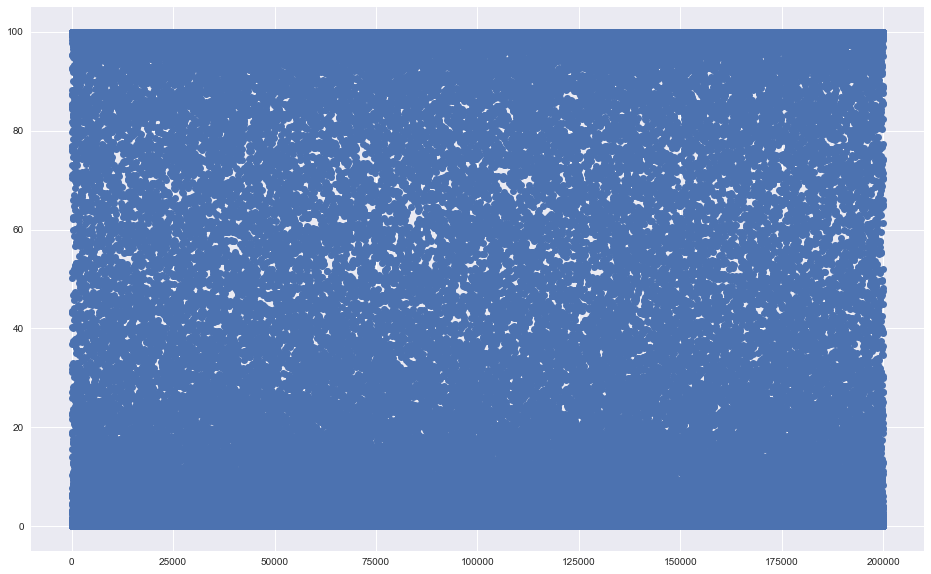

In [28]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(gen_w)), gen_w, linewidths=0.00001)
plt.show()

Нормируем полученные веса

In [29]:
weights = np.ones((n_samples, 1)) #X_train.shape[0]

In [30]:
gen_w_normed = gen_w/np.sum(gen_w)*np.sum(weights)

In [31]:
gen_w_normed.sum(), np.sum(weights)

(200000.0, 200000.0)

In [32]:
y1 = np.zeros((n_samples,1))
y2 = np.ones((gen.shape[0],1))

In [33]:
X_mix = np.vstack((gen, X_good)) 

y_mix = np.vstack((y2, y1))

weights_mix = np.vstack((gen_w_normed.reshape(-1,1), weights.reshape(-1,1))).reshape(-1)

In [34]:
weights_mix.shape

(399993,)

## Обучим на этом нейронку

In [37]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.095
config.gpu_options.visible_device_list = '1'
set_session(tf.Session(config=config))

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
from tensorflow.python.client import device_lib
tf.set_random_seed(1)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

import keras
from keras.models import Sequential
from keras import layers as L
from keras import backend as K
K.set_session(sess)

In [51]:
import os
import tensorflow as tf
tf.set_random_seed(1)

import keras
from keras.models import Sequential
from keras import layers as L
from keras import backend as K

print(device_lib.list_local_devices())

K.tensorflow_backend._get_available_gpus()

Простейшая сверточная сеть для двухклассовой классификации

In [38]:
def build_net():
#     with tf.device('/gpu:2'):
    net = Sequential()
    net.add(L.Dense(80, input_shape=(X_good.shape[1],), activation = 'relu'))
    net.add(L.BatchNormalization())
    net.add(L.Dropout(0.2))
    net.add(L.Dense(32, activation='relu'))
    net.add(L.BatchNormalization())
    net.add(L.Dropout(0.1))
    net.add(L.Dense(1, activation='sigmoid'))

    adam = keras.optimizers.Adam(lr=0.001)
    net.compile(optimizer=adam, loss='binary_crossentropy')
    return net

Строит зависимость ошибок от эпохи

In [39]:
# summarize history for loss
def history_plot(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower left')
    plt.show()

In [52]:
ours_roc_aucs = {}
ours_pr_aucs = {}
ours_p_at_n = {
    10: {},
    100: {},
    200: {},
    500: {},
    1000: {},
    2000: {},
    5000: {},
}
ours_p_at_r = {
    '0.8': {},
    '0.9': {}, 
    '0.95': {},
    '0.99': {},
}

Реализуем функции для вычисления precision at recall и precision at n

In [41]:
def p_at_n(y_test, y_pred, n=10):
    ind = np.argpartition(y_pred[:, 0], -n)[-n:]
    try:
        mean = np.mean(y_test[ind])
    except:
        mean = np.mean(y_test.iloc[ind])
    return mean

In [42]:
def p_at_r(y_test, y_pred, x):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    return max(precision[recall > x])

In [43]:
def _eval_p_at_rs(y_test, y_pred, frac, ours_p_at_r, descr):
    for recall in ours_p_at_r.keys():
        if descr in ours_p_at_r[recall]:
            # append the new number to the existing array at this slot
            ours_p_at_r[recall][descr].append((frac, p_at_r(y_test, y_pred, float(recall))))
        else:
            # create a new array in this slot
            ours_p_at_r[recall][descr] = [(frac, p_at_r(y_test, y_pred, float(recall)))]
            
def _eval_p_at_rs_flatten(y_test, y_pred, frac, ours_p_at_r, descr):
    for recall in ours_p_at_r.keys():
        ours_p_at_r[recall][descr] = (frac, p_at_r(y_test, y_pred, float(recall)))

In [44]:
def _eval_p_at_ns(y_test, y_pred, frac, ours_p_at_n, descr):
    for n in ours_p_at_n.keys():
        if descr in ours_p_at_n[n]:
            # append the new number to the existing array at this slot
            ours_p_at_n[n][descr].append((frac, p_at_n(y_test, y_pred, int(n))))
        else:
            # create a new array in this slot
            ours_p_at_n[n][descr] = [(frac, p_at_n(y_test, y_pred, int(n)))]
            
def _eval_p_at_ns_flatten(y_test, y_pred, frac, ours_p_at_n, descr):
    for n in ours_p_at_n.keys():
        ours_p_at_n[n][descr] = (frac, p_at_n(y_test, y_pred, int(n)))

Посмотрим на значения весов объектов в объединенной выборке

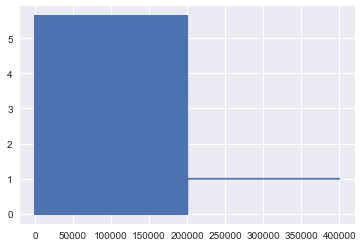

In [45]:
plt.plot(weights_mix)
plt.show()

Сохранение метрик

In [46]:
import json

def dump(saved_dict, folder, name):
    dict_for_json = {k: {kk: list(vv) for kk, vv in v.items()} if isinstance(v, dict) else list(v) 
                     for k, v in saved_dict.items()}
    with open(os.path.join(folder, name + ".json"), 'w', encoding="utf-8") as file:
        # writing
        json.dump(dict_for_json, file, indent=4, ensure_ascii=False)
    del dict_for_json
    
def create_metrics_folder(metrics_path):
    if not os.path.exists(metrics_path):
        os.makedirs(metrics_path)
    try:
        last_folder_n = max(list(map(lambda name: int(name), 
                                     filter(lambda name: os.path.isdir(os.path.join(metrics_path, name)) 
                                            and name.isdecimal(), os.listdir(metrics_path)))))
    except:
        last_folder_n = 0
    new_folder = os.path.join(metrics_path, str(last_folder_n + 1))
    old_folder = os.path.join(metrics_path, str(last_folder_n))
    os.makedirs(new_folder)    
    return new_folder, old_folder

# костыль, чтобы не сохранять разные словари отдельно
def dump_metrics(metrics_path):
    folder, old_folder = create_metrics_folder(metrics_path)
    print(folder)

    dump(ours_pr_aucs, folder, "ours_pr_aucs")
    dump(ours_roc_aucs, folder, "ours_roc_aucs")
    dump(ours_p_at_n, folder, "ours_p_at_n")
    dump(ours_p_at_r, folder, "ours_p_at_r")
    
    shutil.rmtree(old_folder, ignore_errors=True)

Обучим нейронку с нашими весами

Train on 359993 samples, validate on 40000 samples
Epoch 1/130
359993/359993 [==============================] - 1s 4us/step - loss: 0.6563 - val_loss: 0.5946
Epoch 2/130
359993/359993 [==============================] - 1s 2us/step - loss: 0.5819 - val_loss: 0.5122
Epoch 3/130
359993/359993 [==============================] - 1s 2us/step - loss: 0.5500 - val_loss: 0.4330
Epoch 4/130
359993/359993 [==============================] - 1s 2us/step - loss: 0.5239 - val_loss: 0.3702
Epoch 5/130
359993/359993 [==============================] - 1s 2us/step - loss: 0.4978 - val_loss: 0.3187
Epoch 6/130
359993/359993 [==============================] - 1s 2us/step - loss: 0.4669 - val_loss: 0.2693
Epoch 7/130
359993/359993 [==============================] - 1s 2us/step - loss: 0.4315 - val_loss: 0.2307
Epoch 8/130
359993/359993 [==============================] - 1s 2us/step - loss: 0.3941 - val_loss: 0.1944
Epoch 9/130
359993/359993 [==============================] - 1s 2us/step - loss: 0.3589 - val

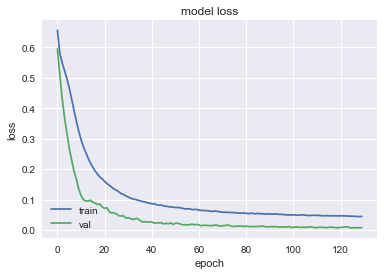

CPU times: user 1min 37s, sys: 19.5 s, total: 1min 57s
Wall time: 1min 25s


In [49]:
%%time
# idx = np.random.permutation(len(y_mix))

net = build_net()
history = net.fit(X_mix, y_mix, 
                  batch_size=10000, epochs=130, validation_split=0.1, verbose=1, shuffle=True, 
                  sample_weight=weights_mix)
history_plot(history)

Посмотрим на результаты и сохраним их

100000/100000 [==============================] - 4s 45us/step
./metrics/our/alpha_0/8

f1_score  0.013268974832648035
confusion_matrix 
[[49991     9]
 [49666   334]]


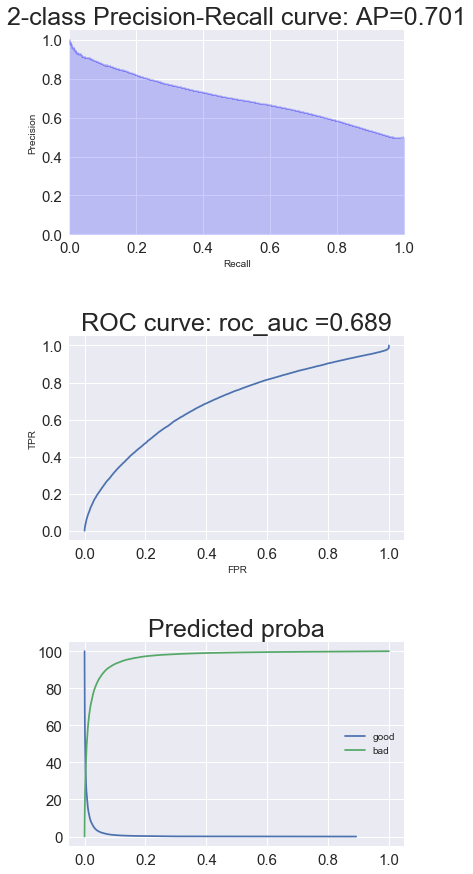

In [53]:
alpha = 0
frac = 0
metrics_path = './metrics/our/alpha_' + str(alpha)

y_pred = net.predict_proba(X_test, verbose=1)
ours_pr_aucs[alpha] = [(frac, average_precision_score(y_test, y_pred))]
ours_roc_aucs[alpha] = [(frac, roc_auc_score(y_test, y_pred))]
_eval_p_at_ns(y_test, y_pred, frac, ours_p_at_n, descr=alpha)
_eval_p_at_rs(y_test, y_pred, frac, ours_p_at_r, descr=alpha)

dump_metrics(metrics_path)

print('')
perfomance(y_test, y_pred)

In [54]:
ours_roc_aucs[alpha]

[(0, 0.6894770598000001)]

In [55]:
ours_pr_aucs[alpha]

[(0, 0.7014806637205524)]

In [56]:
ours_p_at_n[5000][alpha]

[(0, 0.884)]

Похоже алгоритм почти всегда отвечает классом 1 (о чем должен говорить последний график из построения так и не понял?)

## Получим значения при разных долях включения истинных аномалий

Инициализируем веса объектов обратно пропорционально доли класса в выборке

In [57]:
len(y_train)-np.sum(y_train)

200000.0

In [58]:
np.sum(y_train)

200000.0

In [59]:
len(y_train)

400000

In [60]:
len(y_train)/np.where(y_train == 0, len(y_train)-np.sum(y_train), np.sum(y_train))

array([2., 2., 2., ..., 2., 2., 2.])

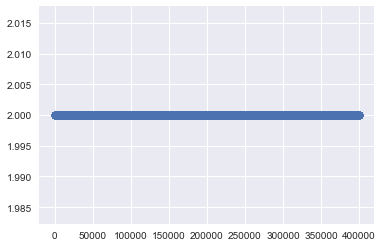

In [61]:
weights_train = np.array(len(y_train)/np.where(y_train == 0.0, len(y_train)-np.sum(y_train), np.sum(y_train)))
plt.scatter(np.arange(len(y_train)), weights_train.ravel())
plt.show()

Графики метрик

In [62]:
def metric_boxplot(metric, ylabel='PR_AUC', ylim=None):
    n = len(metric.keys())
    plt.figure(figsize=(15, 7 * ceil(n/2)))

    for i, clf_name in enumerate(metric.keys()):
        plt.subplot(ceil(n/2), 2, i + 1)
        sns.boxplot(np.array(metric[clf_name])[:, 0], np.array(metric[clf_name])[:, 1])
        plt.ylim(ylim)
        plt.xlabel("% of used anomalies")
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.title(clf_name)

Обучим нейронки при разных долях участия аномалий в выборке(8 долей, $\alpha$=1)

Значения alphas и долей негативных примеров взял из Meeting minutes (29.03.2018)

In [63]:
fraction_of_negative_used = np.array([0, 0.1, 0.5, 1, 5, 10, 25, 100]) / 100.
n_resplits = np.ones_like(fraction_of_negative_used, dtype=np.int) * 10

In [64]:
n_resplits = 10

Run time: 1236.96 sec


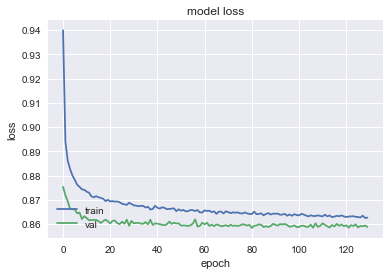

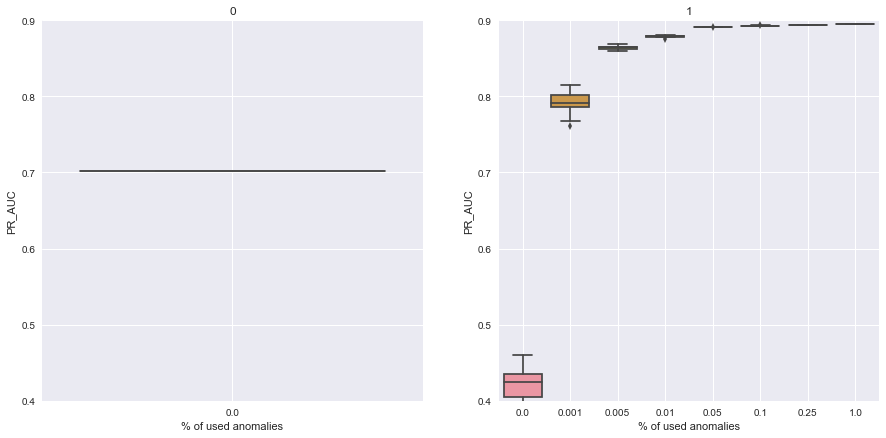

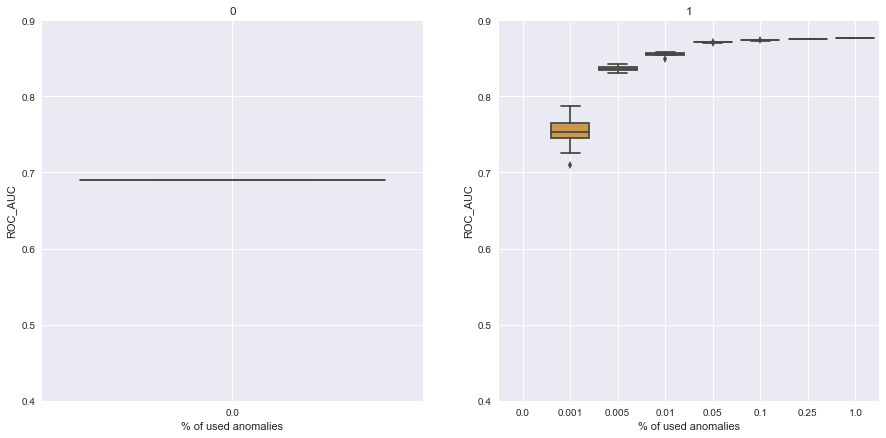

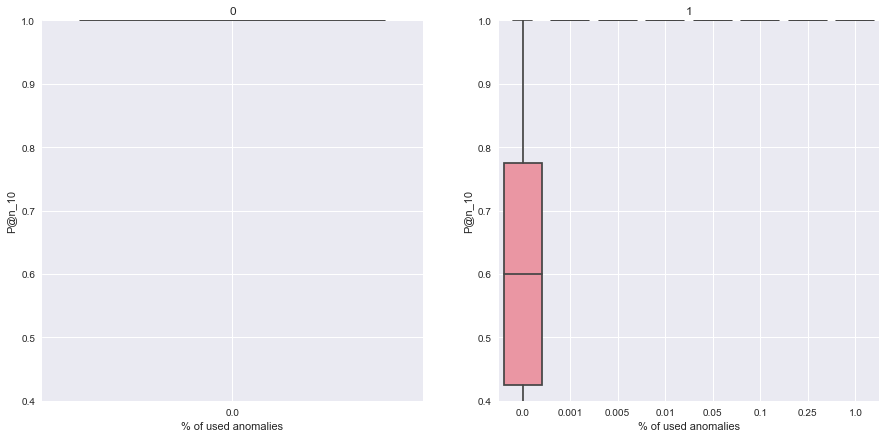

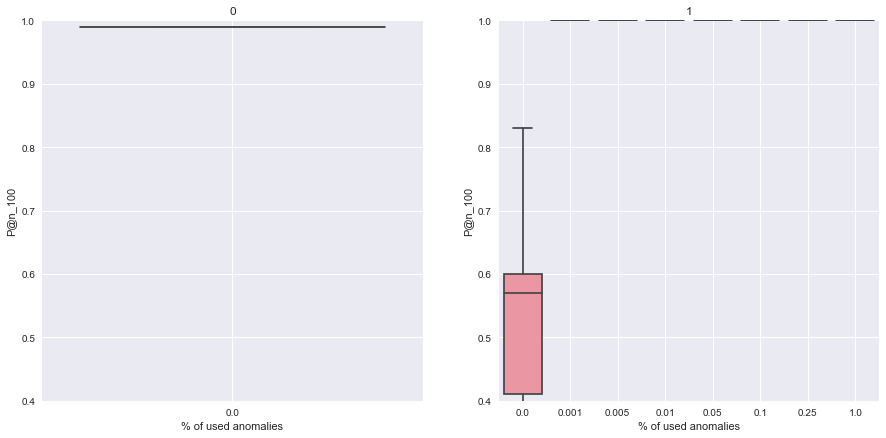

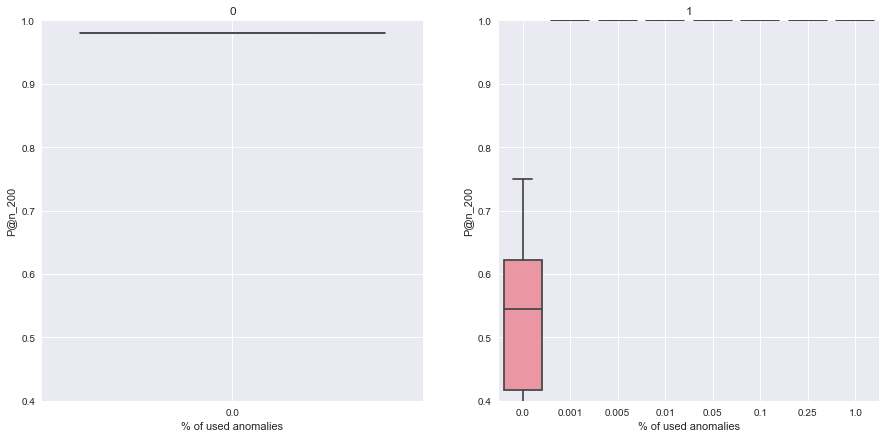

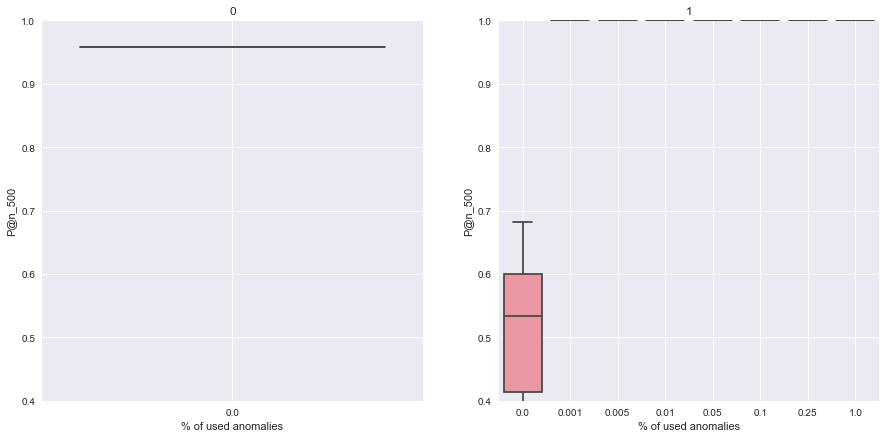

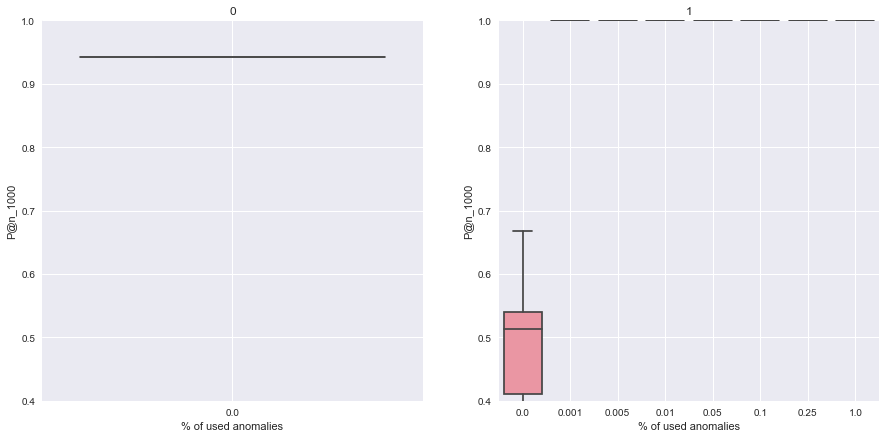

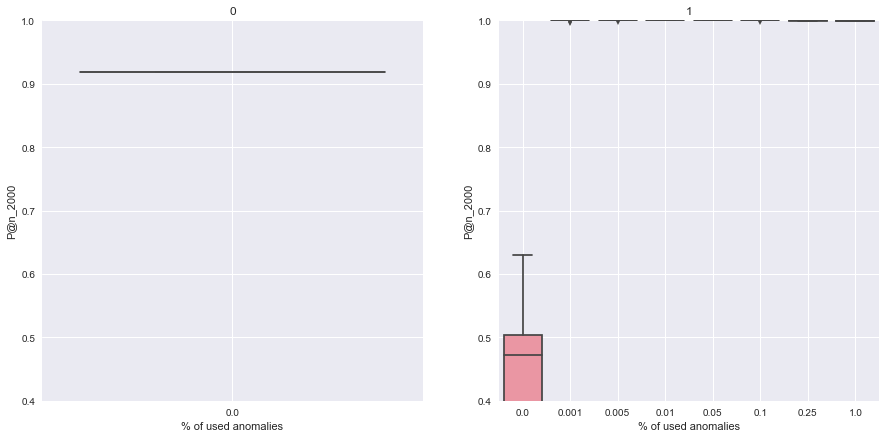

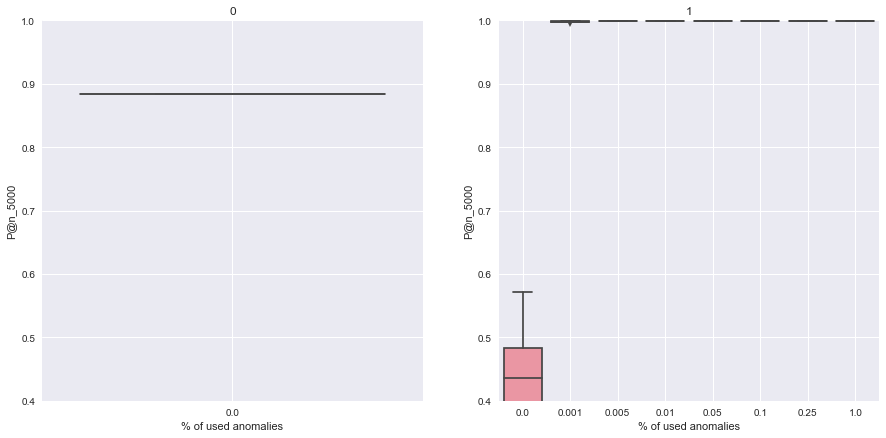

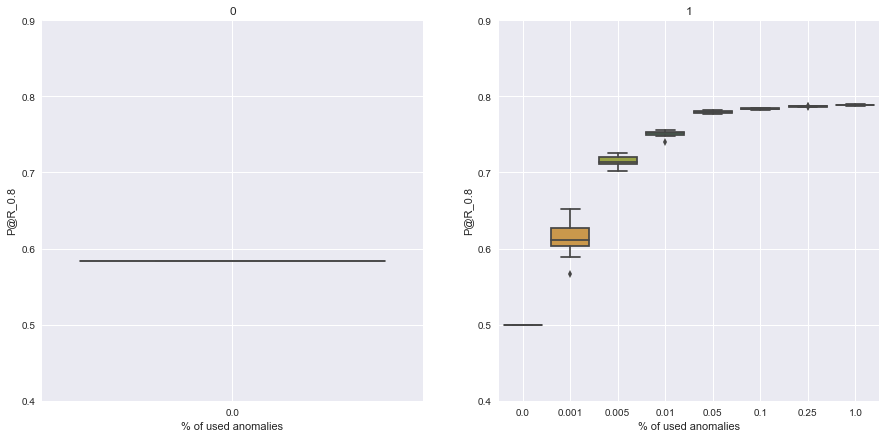

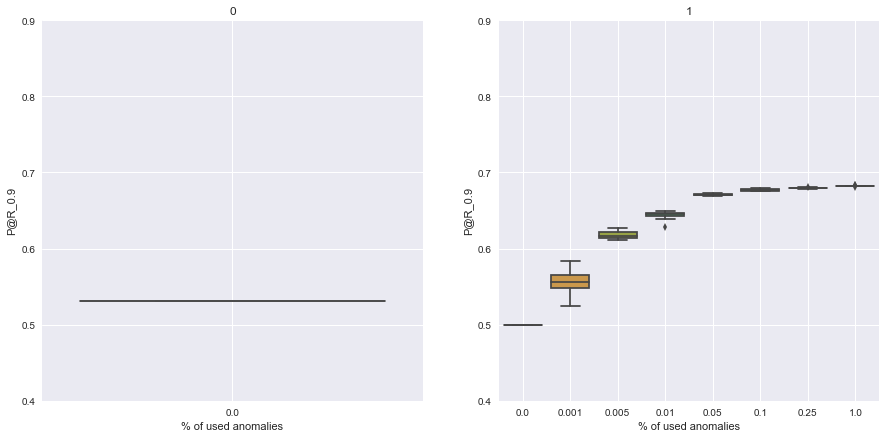

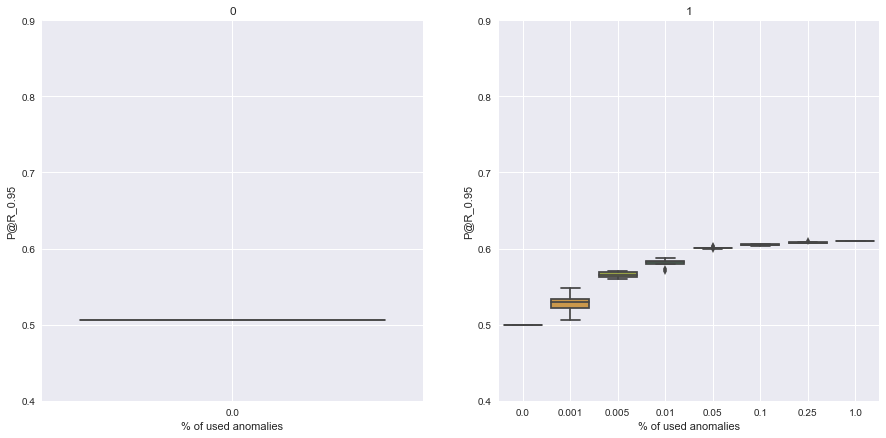

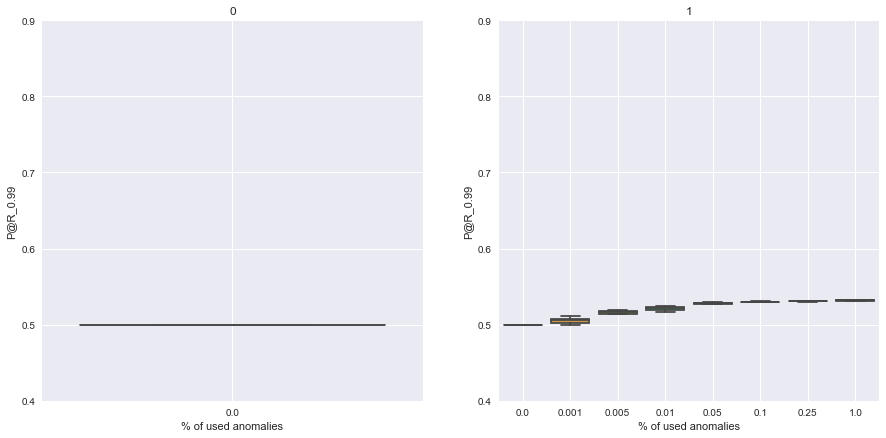


8it [1:41:42, 885.34s/it]
100%|██████████| 10/10 [15:02:00<00:00, 5814.53s/it] 

ROC_AUC:  (1.0, 0.8765869816)
./metrics/our/alpha_1/91
CPU times: user 19h 7min 23s, sys: 4h 44min 3s, total: 23h 51min 27s
Wall time: 15h 2min


In [66]:
%%time
alpha = 1
metrics_path = './metrics/our/alpha_' + str(alpha)
for n_resplit in tqdm(range(n_resplits)):
    for i, frac in tqdm(enumerate(fraction_of_negative_used)):
        if frac > 1:
            end_ind = X_bad.shape[0]
        else:   
            end_ind = int(X_bad.shape[0] * frac)

        idx = np.random.permutation(X_bad.shape[0])


        cur_X = np.concatenate((X_good, X_bad[idx[:end_ind]]))
        cur_y = np.concatenate(
            (np.zeros((X_good.shape[0], 1)), np.ones((end_ind, 1)))
        ).ravel()
        cur_w = np.concatenate(
            (np.min(weights_train)*np.ones((X_good.shape[0], 1)), np.max(weights_train)*np.ones((end_ind, 1)))
        ).ravel()

        idx = np.random.permutation(len(cur_y))
        cur_X, cur_y, cur_w = cur_X[idx], cur_y[idx], cur_w[idx]

        net = build_net()


        start_time = timeit.default_timer()
        history = net.fit(cur_X, cur_y, 
                          batch_size=512, epochs=130, validation_split = 0.1, verbose=0, shuffle=True, 
                          sample_weight=cur_w)
        run_time = timeit.default_timer() - start_time

        y_pred=net.predict_proba(X_test)
        if alpha in ours_pr_aucs:
            # append the new number to the existing array at this slot
            ours_pr_aucs[alpha].append((frac, average_precision_score(y_test, y_pred)))
            ours_roc_aucs[alpha].append((frac, roc_auc_score(y_test, y_pred)))
        else:
            # create a new array in this slot
            ours_pr_aucs[alpha] = [(frac, average_precision_score(y_test, y_pred))]
            ours_roc_aucs[alpha] = [(frac, roc_auc_score(y_test, y_pred))]
        _eval_p_at_ns(y_test, y_pred, frac, ours_p_at_n, descr=alpha)
        _eval_p_at_rs(y_test, y_pred, frac, ours_p_at_r, descr=alpha)


        # plot metrics
        display.clear_output(wait=True)
        print("Run time: {:.2f} sec".format(run_time))
        history_plot(history)
        metric_boxplot(ours_pr_aucs, ylabel='PR_AUC', ylim=(0.4, 0.9))
        plt.show()
        metric_boxplot(ours_roc_aucs, ylabel='ROC_AUC', ylim=(0.4, 0.9))
        plt.show()
        for k in ours_p_at_n.keys():
            metric_boxplot(ours_p_at_n[k], ylabel='P@n_' + str(k), ylim=(0.4, 1))
            plt.show()
        for k in ours_p_at_r.keys():
            metric_boxplot(ours_p_at_r[k], ylabel='P@R_' + str(k), ylim=(0.4, 0.9))
            plt.show()
        print("ROC_AUC: ", ours_roc_aucs[alpha][-1])

        dump_metrics(metrics_path)

Обучим нейронки при разных долях участия аномалий в выборке(3 $\alpha$ * 8 долей)

In [ ]:
# points_cnt = 10
# alphas = np.exp([np.log(0.05) * (points_cnt - i) * 1/points_cnt for i in range(points_cnt)]) # log scale
# alphas = [0.05, 0.1, 0.3, 0.5, 0.9]
alphas = [0.1, 0.25, 0.5]

In [ ]:
print(alphas)

Функция обновления весов

Вклад нейтральных и отрицательных объектов одинаковый

В отрицательных вклад истинных аномалий=$\alpha$, а сгенерированных=$(1 - \alpha)$

In [ ]:
def upd_weights(alpha, y_mix, num_true_bad, w_g=gen_w_normed):
    # sum of weights for good and bad data: beta * bad + (1 - beta) * good
    # proportion of weights between real and fake data id alpha: alpha * true + (1 - alpha) * fake
    num_good = len(y_mix)-np.sum(y_mix)
    num_fake_bad = np.sum(y_mix)
    sum_w = num_good+num_fake_bad+num_true_bad
    
    beta = 0.5
    w_good = (1-beta)/num_good * np.ones((int(num_good),1))
    
    w_fake_bad = (1-alpha)*beta/num_fake_bad * w_g
    w_fake_bad = w_fake_bad.reshape(-1,1)
    
    if num_true_bad!=0:
        w_true_bad = alpha*beta/num_true_bad *np.ones((int(num_true_bad),1))
    else:
        w_true_bad=np.empty((0,1))
                           
    return sum_w*np.vstack((w_fake_bad, w_good, w_true_bad))

In [ ]:
%%time

for n_resplit in tqdm(range(n_resplits)):
    for alpha in tqdm(alphas):
        metrics_path = './metrics/our/alpha_' + str(alpha)
        for i, frac in tqdm(enumerate(fraction_of_negative_used)):
            if frac > 1:
                end_ind = X_bad.shape[0]
            else:   
                end_ind = int(X_bad.shape[0] * frac)

            idx = np.random.permutation(X_bad.shape[0])

            cur_X = np.concatenate((X_good, X_bad[idx[:end_ind]]))
            cur_y = np.concatenate(
                (np.zeros((X_good.shape[0], 1)), np.ones((end_ind, 1)))
            ).ravel()
            cur_w = np.concatenate(
                (np.min(weights_train)*np.ones((X_good.shape[0], 1)), np.max(weights_train)*np.ones((end_ind, 1)))
            ).ravel()

            idx = np.random.permutation(len(cur_y))
            cur_X, cur_y, cur_w = cur_X[idx], cur_y[idx], cur_w[idx]

            net = build_net()
            start_time = timeit.default_timer()
            history = net.fit(cur_X, cur_y, 
                              batch_size=512, epochs=130, validation_split = 0.1, verbose=0, shuffle=True, 
                              sample_weight=cur_w)
            run_time = timeit.default_timer() - start_time

            y_pred=net.predict_proba(X_test)
            if alpha in ours_pr_aucs:
                # append the new number to the existing array at this slot
                ours_pr_aucs[alpha].append((frac, average_precision_score(y_test, y_pred)))
                ours_roc_aucs[alpha].append((frac, roc_auc_score(y_test, y_pred)))
            else:
                # create a new array in this slot
                ours_pr_aucs[alpha] = [(frac, average_precision_score(y_test, y_pred))]
                ours_roc_aucs[alpha] = [(frac, roc_auc_score(y_test, y_pred))]
            _eval_p_at_ns(y_test, y_pred, frac, ours_p_at_n, descr=alpha)
            _eval_p_at_rs(y_test, y_pred, frac, ours_p_at_r, descr=alpha)


            # plot metrics
            display.clear_output(wait=True)
            print("Run time: {:.2f} sec".format(run_time))
            history_plot(history)
            metric_boxplot(ours_pr_aucs, ylabel='PR_AUC', ylim=(0.4, 0.9))
            plt.show()
            metric_boxplot(ours_roc_aucs, ylabel='ROC_AUC', ylim=(0.4, 0.9))
            plt.show()
            for k in ours_p_at_n.keys():
                metric_boxplot(ours_p_at_n[k], ylabel='P@n_' + str(k), ylim=(0.4, 1))
                plt.show()
            for k in ours_p_at_r.keys():
                metric_boxplot(ours_p_at_r[k], ylabel='P@R_' + str(k), ylim=(0.4, 0.9))
                plt.show()
            print("ROC_AUC: ", ours_roc_aucs[alpha][-1])

            dump_metrics(metrics_path)

# Classic methods

## Unsupervised

In [72]:
y_test_rescale = np.where(y_test == 0, np.ones((y_test.shape)), -np.ones((y_test.shape)))

In [81]:
unsupervised_pr_aucs = {}
unsupervised_roc_aucs = {}
unsupervised_p_at_n = {
    10: {},
    100: {},
    200: {},
    500: {},
    1000: {},
    2000: {},
    5000: {},
}
unsupervised_p_at_r = {
    '0.8': {},
    '0.9': {}, 
    '0.95': {},
    '0.99': {},
}

In [74]:
def dump_metrics_un(metrics_path):
    folder, old_folder = create_metrics_folder(metrics_path)
    print(folder)

    dump(unsupervised_pr_aucs, folder, "unsupervised_pr_aucs")
    dump(unsupervised_roc_aucs, folder, "unsupervised_roc_aucs")
    dump(unsupervised_p_at_n, folder, "unsupervised_p_at_n")
    dump(unsupervised_p_at_r, folder, "unsupervised_p_at_r")
    
    shutil.rmtree(old_folder, ignore_errors=True)

In [75]:
def p_at_n_un(y_test, y_pred, n=10):
    try:
        ind = np.argpartition(y_pred[:, 0], -n)[-n:]
    except:
        ind = np.argpartition(y_pred, -n)[-n:]
    try:
        mean = np.mean(y_test[ind])
    except:
        mean = np.mean(y_test.iloc[ind])
    return mean

In [76]:
def _eval_p_at_ns(y_test, y_pred, frac, ours_p_at_n, descr):
    for n in ours_p_at_n.keys():
        if descr in ours_p_at_n[n]:
            # append the new number to the existing array at this slot
            ours_p_at_n[n][descr].append((frac, p_at_n_un(y_test, y_pred, int(n))))
        else:
            # create a new array in this slot
            ours_p_at_n[n][descr] = [(frac, p_at_n_un(y_test, y_pred, int(n)))]
            
def _eval_p_at_ns_flatten(y_test, y_pred, frac, ours_p_at_n, descr):
    for n in ours_p_at_n.keys():
        ours_p_at_n[n][descr] = (frac, p_at_n_un(y_test, y_pred, int(n)))

0it [00:00, ?it/s]

One-Class SVM
recall_score  0.16634
precision_score  0.8543400102722136
f1_score  0.27846321252197204
confusion_matrix 
[[48582  1418]
 [41683  8317]]


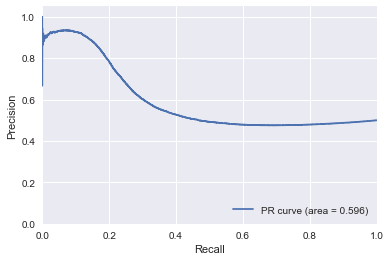

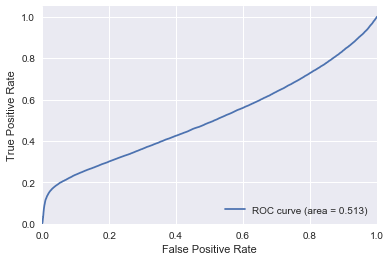

1it [20:34, 1234.38s/it]

Precision at recall:  0.8 = [(0, 0.5)]; 0.9 = [(0, 0.5)]; 0.95 = [(0, 0.5)]; 0.99 = [(0, 0.5)]
./metrics/unsupervised/5
Isolation Forest
recall_score  0.33444
precision_score  0.9186397846508817
f1_score  0.49035966159846345
confusion_matrix 
[[48519  1481]
 [33278 16722]]


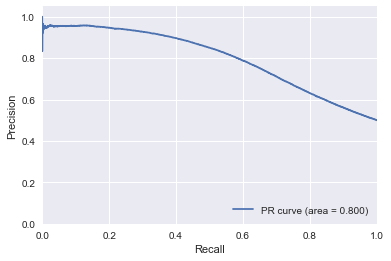

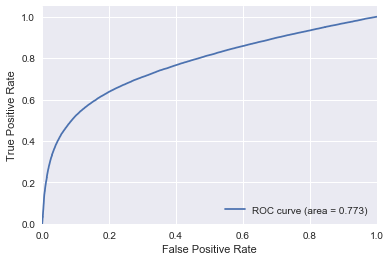

2it [23:33, 917.70s/it] 

Precision at recall:  0.8 = [(0, 0.6308386160784685)]; 0.9 = [(0, 0.5611991669680381)]; 0.95 = [(0, 0.5292708472612203)]; 0.99 = [(0, 0.5064869953138109)]
./metrics/unsupervised/6


In [82]:
from sklearn import svm
from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor


classifiers_classic_uns = {
    "One-Class SVM": svm.OneClassSVM(nu=0.03,
                                     kernel="rbf", gamma=1e-5),
    "Isolation Forest": IsolationForest(n_estimators=500,
                                        max_samples=1500,
                                        contamination=0.03,
                                        random_state=10)
}

frac = 0
metrics_path = './metrics/unsupervised/'
for i, (clf_name, clf) in tqdm(enumerate(classifiers_classic_uns.items())):
        clf.fit(X_good)
        #scores_pred = clf.decision_function(X_test)
        y_pred = clf.predict(X_test)
#         y_pred = clf.decision_function(X_test)
        
        print (clf_name)
        print ("recall_score ",recall_score(-y_test_rescale, np.round(-y_pred)))
        print ("precision_score ",precision_score(-y_test_rescale, np.round(-y_pred)))
        print ("f1_score ",f1_score(-y_test_rescale, np.round(-y_pred)))
        print ("confusion_matrix ")
        print (confusion_matrix(-y_test_rescale, np.round(-y_pred)))
        

        Score = clf.decision_function(X_test)
        
        
        precision, recall, _ = precision_recall_curve(-y_test_rescale, -Score)
        pr_auc = auc(recall, precision)
        unsupervised_pr_aucs[clf_name]=[(frac, pr_auc)]
        
        plt.figure()
        plt.plot(recall, precision, label='PR curve (area = %0.3f)' % pr_auc)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
        
        fpr, tpr, _ = roc_curve(-y_test_rescale, -Score)
        roc_auc = auc(fpr, tpr)
        unsupervised_roc_aucs[clf_name]=[(frac, roc_auc)]
        
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
        
        _eval_p_at_rs(-y_test_rescale, -Score, frac, unsupervised_p_at_r, descr=clf_name)
        _eval_p_at_ns(-y_test_rescale, -Score, frac, unsupervised_p_at_n, descr=clf_name)
        
        print("Precision at recall: ", "; ".join(
            map(lambda k: "{} = {}".format(k, unsupervised_p_at_r[k][clf_name]), unsupervised_p_at_r.keys())
        ))
        dump_metrics_un(metrics_path)